In [1]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

n_points = 600
time = np.arange(n_points)


X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)


for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.5 * X1[t-1] + 0.2)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] + 0.2)



X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

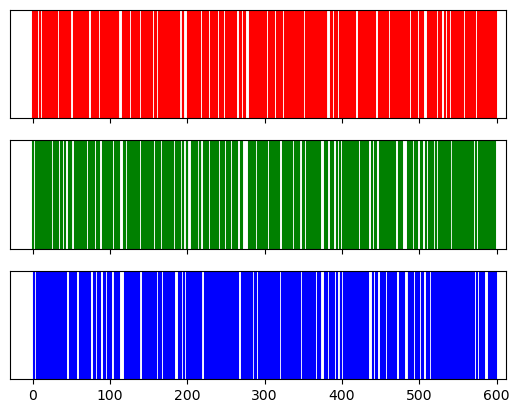

In [2]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    device = "cuda"
else:
    torch.set_default_tensor_type("torch.FloatTensor")
    device = "cpu"


In [4]:
# hidden_dim = 16
# thiago = nn.GRU(input_size = hidden_dim, hidden_size = int(2*hidden_dim), num_layers = 2, batch_first = True)
# sum(p.numel() for p in thiago.parameters())

In [5]:
# mlp = nn.Sequential(nn.Linear(hidden_dim, 2*hidden_dim), nn.Linear(2*hidden_dim, 2*hidden_dim))
# 7*sum(p.numel() for p in mlp.parameters())

In [6]:
class CustomNet(nn.Module):
    def __init__(self, num_features, memory_size, hidden_dim):
        super().__init__()
        
        self.embd = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.Tanh())
        
        self.rnn = nn.GRU(input_size = hidden_dim, hidden_size = int(2*hidden_dim), num_layers = 2, batch_first = True)
        
        self.conv1d = nn.Sequential(nn.Conv1d(in_channels = memory_size//2, out_channels = 1, kernel_size = 1), nn.Tanh())
        self.fc = nn.Linear(2*hidden_dim, memory_size)

    def forward(self, x):
        
        ## in (10, 1, 2) ## change to into (10, 2, 1) and embed (10, 2, 32)
        
        x = x.permute(0,2,1)
        #print(x.shape)
        x = self.embd(x)
        #print(x.shape)
        x, _ = self.rnn(x) # (10, 2, 32) -> (10, 2, 64)
        #print(x.shape)
        x = self.conv1d(x) # (10, 2, 64) -> (10, 1, 64)
        #print(x.shape)
        x = self.fc(x) # (10, 1, 64) -> (10, 1, 4)
                

        return x

model = CustomNet(num_features=1, hidden_dim=32, memory_size = 4)

x = torch.rand(size = (10, 1, 2))

model(x).shape

torch.Size([10, 1, 4])

In [7]:
from torch.distributions import Normal 


# class CustomNet(nn.Module):
#     def __init__(self, num_features, memory_dim, hidden_dim):
#         super().__init__()
        
#         self.embd = nn.Sequential(
#             nn.Linear(num_features, hidden_dim),
#             nn.Tanh())
        
#         self.rnn = nn.GRU(input_size = memory_dim//2, hidden_size = int(2*hidden_dim), num_layers = 2, batch_first = True)
        
#         self.conv1d = nn.Sequential(nn.Conv1d(in_channels = 2*hidden_dim, out_channels = 1, kernel_size = 1), nn.Tanh())
#         self.fc = nn.Linear(hidden_dim, memory_dim)

#     def forward(self, x):
        
#         ## in (10, 1, 2) ## change to into (10, 2, 1) and embed (10, 2, 32)
        
#         x = x.permute(0,2,1)
        
#         x = self.embd(x)
#         x, _ = self.rnn(x) # (10, 2, 32) -> (10, 64, 32)
#         x = self.conv1d(x) # (10, 64, 32) -> (10, 1, 32)
#         x = self.fc(x) # (10, 1, 32) -> (10, 1, 4)
                

        # return x

class AffineCouplingLayer(nn.Module):
    def __init__(self, num_features, hidden_dim, memory_size):
        super(AffineCouplingLayer, self).__init__()
        
        self.net = CustomNet(num_features=num_features, hidden_dim=hidden_dim, memory_size=memory_size)
        
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)
        params = self.net(x1)
        shift, log_scale = params.chunk(2, dim=-1)
        z2 = (x2 - shift) * torch.exp(-log_scale)
        z = torch.cat([x1, z2], dim=-1)
        log_det_jacobian = -log_scale.sum(dim=(1,2))
        
        return z, log_det_jacobian

    def inverse(self, z):
        z1, z2 = z.chunk(2, dim=1)
        params = self.net(z1)
        shift, log_scale = params.chunk(2, dim=1)
        x2 = z2 * torch.exp(log_scale) + shift
        x = torch.cat([z1, x2], dim=1)
        
        return x

class InvConv1D(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        # Initialize an orthogonal matrix for 1x1 convolution in 1D
        w_init, _ = torch.linalg.qr(torch.randn(num_features, num_features))
        #w_init = torch.tensor(w_init)

        self.register_buffer('w', w_init)
        self.w_inverse = None

    def forward(self, x):
        # x is of shape (batch_size, num_features)
        # Apply the learned 1x1 convolution (linear transformation)
        z = x @ self.w  # Matrix multiplication for 1D

        # Compute log determinant of the Jacobian for the flow
        log_det_jacobian = torch.slogdet(self.w)[1]
        
        return z, log_det_jacobian

    def inverse(self, z):
        if self.w_inverse is None:
            self.w_inverse = torch.inverse(self.w)
        x = z @ self.w_inverse
        
        return x



class NFBlock(nn.Module):
    def __init__(self, num_features, hidden_dim, memory_size):
        super().__init__()
        self.invertible_conv = InvConv1D(memory_size)
        self.affine_coupling = AffineCouplingLayer(num_features = num_features, hidden_dim = hidden_dim, memory_size = memory_size)

    def forward(self, x):
        z, log_det_jacobian_conv = self.invertible_conv(x)
        
        z, log_det_jacobian_affine = self.affine_coupling(z)
        
        log_det_jacobian = log_det_jacobian_conv + log_det_jacobian_affine
        
        return z, log_det_jacobian

    def inverse(self, z):
        x = self.affine_coupling.inverse(z)
        x = self.invertible_conv.inverse(x)
        
        return x



class NormalizingFlow(nn.Module):
    def __init__(self, num_features, memory_size, hidden_dim, num_layers):
        super(NormalizingFlow, self).__init__()
        self.num_features = num_features
        self.memory_size = memory_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.base_dist = Normal(0, 1)
        self.blocks = nn.ModuleList(
            [NFBlock(num_features = num_features, memory_size = memory_size, hidden_dim = hidden_dim) for _ in range(num_layers)]
        )
        
    
    def forward(self, x):
        log_det_jacobian = 0
        
        for layer in self.blocks:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.blocks):
            z = layer.inverse(z)
        return z


    def log_prob(self, x):
        z, ldj = self.forward(x)
        log_pz = self.base_dist.log_prob(z).sum(dim = (1,2))
        log_px = log_pz + ldj

        return z, log_px



In [8]:
model = NormalizingFlow(memory_size= 4, num_features=1, hidden_dim = 64, num_layers=3)
# model = CustomNet(num_features=1, hidden_dim=32, memory_dim = 4)

# x = torch.rand(size = (10, 1, 4))

# model(x)

In [9]:
class Memory:

  def __init__(self, size):
    self.size = size
    self.stack = []

  def push(self, item):
    if len(self.stack) >= self.size:
      self.stack.pop()
    self.stack.append(item)

  def pop(self):
    if self.stack:
      return self.stack.pop()
    else:
      return None

  def __repr__(self):
    return repr(self.stack)
  
  def copy(self):
    return self.stack.copy()

In [10]:
class GrangerMPP(nn.Module):

    def __init__(self, processes, memory_dim : int = 10):

        super().__init__()

        self.processes = processes
        self.memory_dim = memory_dim
        self.n_processes = len(self.processes)

       ###


        self.GrangerMatrix = nn.Parameter((torch.empty(self.n_processes, self.n_processes)))
        nn.init.eye_(self.GrangerMatrix)#, mean=0.5, std=0.1) # very important
      
        self.models = nn.ModuleList([NormalizingFlow(num_features = 1, memory_size = self.memory_dim, hidden_dim = 16, num_layers = 2) for i in range(self.n_processes)])
        #self.sweep_dict = self.make_sweep_dict()
        self.sweep_dict = self.make_wold_dict()
        self.time_of_start = self.get_time_of_start()
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()), lr=1e-4, weight_decay = 1e-5) for i in range(self.n_processes)]
        self.g_optimizer = torch.optim.Adam([self.GrangerMatrix], lr = 1e-3, weight_decay=1e-5)
        self.log_GrangerMatrix = []


    def em_step(self, n_steps):
        dic = {}
        self.causes = [[], [], []]
        for i in range(self.n_processes):
            dic[i] = []


        taus = torch.linspace(1, 0.3, steps = n_steps)#
        
        for self.step in range(n_steps):
          for i_proc in range(self.n_processes):
              self.causes[i_proc] = []
              curr = processes[i_proc]
              len_curr = len(curr)
              idx_start = 0
              while idx_start < len_curr:
                self.num_events = 5
                events = self.get_events(self.num_events, idx_start, i_proc, 1.0) ## the get_events does the e_step!
                if events:
                  DL = DataLoader(events, batch_size = len(events))

                  for X, cause_rank in DL:
                    X = X.unsqueeze(1)
                    loss = self.m_step(i_proc, X, cause_rank)
                    dic[i_proc].append(loss)

                idx_start += self.num_events

              if (self.step + 1) % 5 == 0 or self.step == 0:
                  print(f'Step: {self.step + 1}, Model: {i_proc}, Loss: {loss}')


        return dic

    def m_step(self, i_proc, X, cause_rank):

        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        self.g_optimizer.zero_grad()
        z, logp = model.log_prob(X)
        loss = -1*logp

        loss_rnn = (loss * cause_rank).sum()  + -1*(torch.log(cause_rank + 1e-7)).sum() + 0.001*self.GrangerMatrix[i_proc].norm(p=1)


        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):


            loss_rnn.backward(retain_graph = True)

            self.optimizers[i_proc].step()
            self.g_optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.clone().detach())


        else:
            print(f'NaN found in epoch: {self.step}')

        return loss_rnn.item()

    def make_sweep_dict(self):

        dic = {}
        for i in range(self.n_processes):
            target = self.processes[i]
            dic[i] = {}
            for j in range(self.n_processes):
                cause = self.processes[j]
                dic[i][j] = self.sweep(target, cause)

        return dic


    def sweep(self, pa, pc):
        events = []
        pa_indices = []


        for i, ia in enumerate(pa):
            events.append((ia, 'a'))
            pa_indices.append(i)

        for ic in pc:
            events.append((ic, 'c'))

        lim = self.memory_dim

        events.sort()
        mem = []
        ret = []
        index_start = False

        pa_idx_counter = 0  # Counter to track which index in pa we are at

        for t, e in events:
            if e == 'c':
                if len(mem) >= lim:
                    mem.pop(0)
                mem.append(t)

            if e == 'a':
                # Memory is not full yet
                if len(mem) < lim:
                    pa_idx_counter += 1  # Move to the next pa index
                    continue
                # Retrieve deltas from this time to the cause times
                pp = [t - tc for tc in mem]
                ret.append(pp)
                if not index_start:
                  index_start = pa_indices[pa_idx_counter] # Save index relative to pa
                pa_idx_counter += 1  # Move to the next pa index
        if not index_start:
            index_start = -1
        return torch.tensor(ret, dtype=torch.float), index_start

    def construct_wold_dict(self):
        dict = {}

        events = []
        for id, process in enumerate(self.processes):
            for t in process:
                events.append((t.item(), id))
      
        events.sort()

        deltas = {}
        last = {}
        cur = -1

        for t, id in events:
            dict[t] = {}
            deltas[id] = Memory(self.memory_dim)
            last[id] = [0, 0]

        for t, id in events:
            if t != cur:
                
                # updating
                cur = t
                for _id, _delta in deltas.items():
                    dict[cur][_id] = _delta.copy()
            
            last[id][1] = last[id][0]
            last[id][0] = t
            if last[id][1] != 0:
                deltas[id].push(last[id][0] - last[id][1])
            
        return dict
      
    # TODO: check idx_start semantics
    def make_wold_dict(self):
        wold = self.construct_wold_dict()
        dic = {}
        for i in range(self.n_processes):
            target = self.processes[i]
            dic[i] = {}
            #for j in range(self.n_processes):
            #    cause = self.processes[j]
            #    dic[i][j] = self.sweep(target, cause)
            start = {}
            ret = {}
            for _t in target:
                t = _t.item()
                for j in range(self.n_processes):
                    if j not in start:
                        start[j] = 0
                        ret[j] = []
                    #print(wold)
                    #print(type(next(iter(wold.keys())).item()))
                    #print(type(_t.item()))
                    #print(wold[_t][j])
                    if len(wold[t][j]) < self.memory_dim:
                        start[j] += 1
                    else:
                        ret[j].append(wold[t][j])

            for j in range(self.n_processes):
                dic[i][j] = (torch.tensor(ret[j], dtype=torch.float), start[j])

        return dic
       

    def get_time_of_start(self):

      indexs = []
      dic = self.sweep_dict

      for i in dic:
        curr = []
        for j in dic[i]:
          curr.append(dic[i][j][1])
        indexs.append(curr)

      return indexs


    def new_e_step(self, num_events, i_proc, tau):

      in_ = self.GrangerMatrix[i_proc]#.softmax(dim = 0)
      rv = []
      for i in range(num_events):
        cause = F.gumbel_softmax(
            in_,
            tau = tau,
            hard = False
        )
        rv.append(cause)

      self.causes[i_proc].append(rv)

      return rv


    def get_events(self, num_events, idx_start, i_proc, tau):

      begin_of_influences = self.time_of_start[i_proc]
      n_causes = self.new_e_step(num_events, i_proc, tau)

      event_cause = []

      for time in range(num_events):
        causes = n_causes[time]

        for idx_cause, cause in enumerate(causes):
          inf_begin = begin_of_influences[idx_cause]

          if inf_begin == -1: ## this process cannot be caused by this other process (it started after the current process ended)
            continue

          else:
            if time + idx_start >= inf_begin and len(self.sweep_dict[i_proc][idx_cause][0]) > time + idx_start + inf_begin: ## checking if the current_timestamp could be cause by the process and if there's events pass this time
              app = (self.sweep_dict[i_proc][idx_cause][0][time + idx_start - inf_begin], cause)
              event_cause.append(app)

      return event_cause



In [11]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [12]:
mpp = GrangerMPP(processes, memory_dim = 4)
l = mpp.em_step(n_steps = 200)

Step: 1, Model: 0, Loss: 43.26270294189453
Step: 1, Model: 1, Loss: 4.575932502746582
Step: 1, Model: 2, Loss: 13.963117599487305
Step: 5, Model: 0, Loss: 32.518653869628906
Step: 5, Model: 1, Loss: 4.401617527008057
Step: 5, Model: 2, Loss: 8.38979721069336
Step: 10, Model: 0, Loss: 25.439767837524414
Step: 10, Model: 1, Loss: 5.049283027648926
Step: 10, Model: 2, Loss: 5.645739555358887
Step: 15, Model: 0, Loss: 19.55569076538086
Step: 15, Model: 1, Loss: 3.032785415649414
Step: 15, Model: 2, Loss: 5.1080451011657715
Step: 20, Model: 0, Loss: 20.28523063659668
Step: 20, Model: 1, Loss: 2.2919204235076904
Step: 20, Model: 2, Loss: 5.124758720397949
Step: 25, Model: 0, Loss: 8.545748710632324
Step: 25, Model: 1, Loss: 4.542021751403809
Step: 25, Model: 2, Loss: 4.295915603637695
Step: 30, Model: 0, Loss: 3.2861742973327637
Step: 30, Model: 1, Loss: 0.07093892246484756
Step: 30, Model: 2, Loss: 2.557328939437866
Step: 35, Model: 0, Loss: 10.097149848937988
Step: 35, Model: 1, Loss: 0.77

Len of losses: [13400, 11600, 13000]


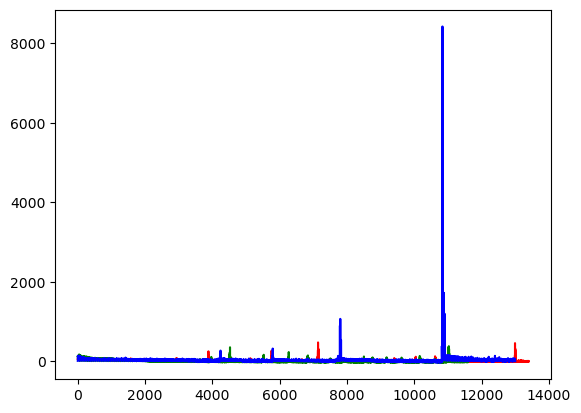

In [13]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

In [14]:
# mpp.models

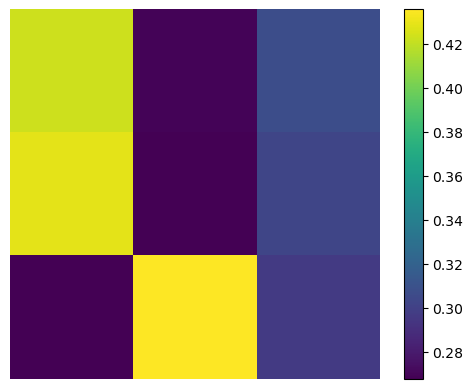

In [15]:
matrix = mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

plt.imshow(matrix)
plt.axis('off')
plt.colorbar()

In [16]:
mpp.GrangerMatrix.softmax(dim = 1).detach().cpu().numpy()

array([[0.42326573, 0.269296  , 0.3074383 ],
       [0.42867732, 0.26817006, 0.30315265],
       [0.26778716, 0.43576688, 0.29644594]], dtype=float32)

In [17]:
len(processes[1])

301

In [18]:
mpp.GrangerMatrix.detach().cpu().numpy()

array([[0.5789098 , 0.12672077, 0.25918412],
       [0.61704385, 0.1479608 , 0.27057588],
       [0.07020478, 0.5571196 , 0.17187712]], dtype=float32)

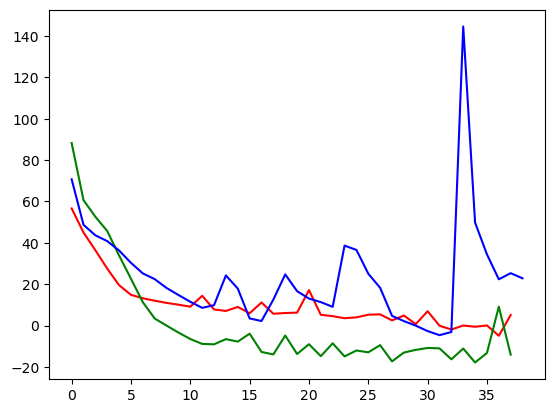

In [19]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [20]:
temp

[70.71694103246782,
 48.708223363248315,
 43.624357416862395,
 40.82705830364692,
 36.28722565566621,
 30.320664936812914,
 25.20505097817357,
 22.44164816126591,
 18.164650521218412,
 14.762412774172134,
 11.504429977089053,
 8.55461648733514,
 9.851539504532589,
 24.22519030004013,
 17.90171596159159,
 3.4426889030898855,
 2.186759754373669,
 12.563136558343725,
 24.731013523732745,
 16.623636107619216,
 13.043553644530022,
 11.321447006955589,
 9.045293040499773,
 38.65104185730764,
 36.560906303001616,
 25.06344836441482,
 18.233824397874542,
 4.696793193659155,
 2.150880619998533,
 -0.034317063142136645,
 -2.6858137624378022,
 -4.642440405265406,
 -3.1275944850242854,
 144.60371100030295,
 49.78393253102535,
 34.41482293626248,
 22.371983179050247,
 25.32333814450994,
 22.846274583708357]

In [21]:
s = [i.argmax().item() for i in mpp.causes[0]]
s = torch.tensor(s)
s.unique(return_counts = True)

AttributeError: 'list' object has no attribute 'argmax'

In [79]:
causes = []
for i in mpp.causes[0]:
    for j in i:
        causes.append(j.argmax().item())
causes = torch.tensor(causes)
causes.unique(return_counts = True)

(tensor([0, 1, 2]), tensor([112, 125, 112]))